### Notebook for the integration and label transfer of myeloid immune cells with `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius-Maximilian-Universität Würzburg**
- **Created on**: 240329
- **Last modified**: 240527

### Import required modules

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                 10.2.0
absl                NA
asttokens           NA
attr                23.2.0
chex                0.1.85
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
docrep              0.3.2
etils               1.7.0
executing           2.0.1
flax                0.8.1
fsspec              2024.2.0
h5py                3.10.0
igraph              0.11.4
importlib_resources NA
ipykernel           6.29.2
ipywidgets          8.1.2
jax                 0.4.19
jaxlib              0.4.19
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
legacy_api_wrap     NA
lightning           2.1.4
lightning_utilities 0.10.1
llvmlite            0.42.0
matplotlib          3.8.3
mizani              0.11.0
ml_collections      NA
ml_dtypes           0.3.2
mpl_toolkits        NA
msgpack             1.

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

### Read in and format individual datasets compartments

- Read in CD45+ immune cells 

In [5]:
MDX_MPC = sc.read_h5ad('../../../data/MDX_MPC.h5ad')
MDX_MPC.obs['genotype'] = MDX_MPC.obs['Condition'].copy()
MDX_MPC.obs['sample'] = MDX_MPC.obs['hash.ID'].copy()
MDX_MPC.obs['donor'] = MDX_MPC.obs['Sample'].copy()
MDX_MPC.obs['seed_labels'] = MDX_MPC.obs['MPC_Annotation'].copy()
MDX_MPC.obs['cell_source'] = 'HIRI-CD45+'
MDX_MPC

AnnData object with n_obs × n_vars = 6305 × 31053
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Library', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5', 'MPC_Annotation', 'genotype', 'sample', 'donor', 'seed_labels', 'cell_source'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [6]:
MDX_MPC.obs['sample'].value_counts()

sample
Hashtag9-TotalA     576
Hashtag10-TotalA    497
Hashtag5-TotalA     488
Hashtag3-TotalA     475
Hashtag2-TotalA     464
Hashtag4-TotalA     432
Hashtag1-TotalA     427
Hashtag7-TotalA     427
Hashtag12-TotalA    416
Hashtag11-TotalA    414
Hashtag14-TotalA    387
Hashtag6-TotalA     363
Hashtag8-TotalA     359
Hashtag15-TotalA    324
Hashtag13-TotalA    256
Name: count, dtype: int64

In [7]:
MDX_MPC = MDX_MPC[MDX_MPC.obs['nFeature_RNA'] > 200]
MDX_MPC = MDX_MPC[MDX_MPC.obs['nFeature_RNA'] < 4000]

MDX_MPC = MDX_MPC[MDX_MPC.obs['nCount_RNA'] < 15000]
MDX_MPC = MDX_MPC[MDX_MPC.obs['nCount_RNA'] > 200]

MDX_MPC = MDX_MPC[MDX_MPC.obs['percent.mt'] < 60]

MDX_MPC

View of AnnData object with n_obs × n_vars = 5451 × 31053
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Library', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5', 'MPC_Annotation', 'genotype', 'sample', 'donor', 'seed_labels', 'cell_source'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [8]:
MDX_POOL_NEW = sc.read_h5ad('../../../data/MDX_POOL_NEW.h5ad')
MDX_POOL_NEW.obs['genotype'] = MDX_POOL_NEW.obs['Condition'].copy()
MDX_POOL_NEW.obs['sample'] = MDX_POOL_NEW.obs['hash.ID'].copy()
MDX_POOL_NEW.obs['donor'] = MDX_POOL_NEW.obs['Sample'].copy()
MDX_POOL_NEW.obs['seed_labels'] = MDX_POOL_NEW.obs['CD45_Annotation'].copy()
MDX_POOL_NEW.obs['cell_source'] = 'HIRI-CD45+'
MDX_POOL_NEW

AnnData object with n_obs × n_vars = 11098 × 31053
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Library', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'CD45_Annotation', 'genotype', 'sample', 'donor', 'seed_labels', 'cell_source'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [9]:
MDX_POOL_NEW = MDX_POOL_NEW[MDX_POOL_NEW.obs['nFeature_RNA'] > 200]
MDX_POOL_NEW = MDX_POOL_NEW[MDX_POOL_NEW.obs['nFeature_RNA'] < 4000]

MDX_POOL_NEW = MDX_POOL_NEW[MDX_POOL_NEW.obs['nCount_RNA'] < 15000]
MDX_POOL_NEW = MDX_POOL_NEW[MDX_POOL_NEW.obs['nCount_RNA'] > 200]

MDX_POOL_NEW = MDX_POOL_NEW[MDX_POOL_NEW.obs['percent.mt'] < 60]

MDX_POOL_NEW

View of AnnData object with n_obs × n_vars = 10114 × 31053
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Library', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'CD45_Annotation', 'genotype', 'sample', 'donor', 'seed_labels', 'cell_source'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

- Read in Meyer annotated PBMC cells

In [11]:
pbmc = sc.read_h5ad('../../../data/meyer_nikolic_healthy_pbmc_raw.h5ad') 
pbmc

AnnData object with n_obs × n_vars = 173684 × 33559
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states'
    var: 'name'

In [12]:
pbmc_healthy = pbmc[pbmc.obs['COVID_status'].isin(['Healthy'])]
pbmc_healthy.obs['sample'] = pbmc_healthy.obs['sample_id'].copy()
pbmc_healthy.obs['seed_labels'] = pbmc_healthy.obs['annotation_detailed'].copy()
pbmc_healthy.obs['cell_source'] = 'Sanger-Cells'
pbmc_healthy.obs['genotype'] = 'human'
pbmc_healthy

AnnData object with n_obs × n_vars = 173684 × 33559
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype'
    var: 'name'

In [13]:
pbmc_healthy.var_names = [gene_name.capitalize() for gene_name in pbmc_healthy.var_names]
pbmc_healthy.var_names

Index(['Mir1302-2hg', 'Fam138a', 'Or4f5', 'Al627309.1', 'Al627309.3',
       'Al627309.2', 'Al627309.4', 'Al732372.1', 'Or4f29', 'Ac114498.1',
       ...
       'Viral-hhv-6a-(human-herpes-virus-6)',
       'Viral-hhv-6b-(human-herpes-virus-6)',
       'Viral-herpes-simplex-virus-1-(human-alphaherpesvirus-1)',
       'Viral-herpes-simplex-virus-2-(human-alphaherpesvirus-1)',
       'Viral-measles-morbillivirus', 'Viral-mumps-rubulavirus',
       'Viral-rubella',
       'Viral-varicella-zoster-virus-(vzv-human-alphaherpesvirus-3)',
       'Viral-cytomegalovieus-(cmv)', 'Viral-sars-cov2'],
      dtype='object', length=33559)

### Read in DMD query cells

In [14]:
DMD_scANVI = sc.read_h5ad('../../../data/heart_mm_nuclei-23-0092_scANVI-Immune_ctl240329.raw.h5ad')
DMD_scANVI

AnnData object with n_obs × n_vars = 81644 × 27478
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment', 'C_scANVI_new'
    var: 'gene_ids-DMD_immune', 'feature_types-DMD_immune', 'genome-DMD_immune', 'mt-DMD_immune', 'ribo-DMD_immune', 'n_cells_by_counts-DMD_immune', 'mean_counts-DMD_immune', 'pct_dropout_by_counts-DMD_immune', 'total_counts-DMD_immune', 'vst.m

In [15]:
DMD_scANVI.obs_names

Index(['AAACCCAGTCAAGCGA-1_1-MDX_POOL_NEW',
       'AAACCCAGTGGCTTGC-1_1-MDX_POOL_NEW',
       'AAACGCTGTAGTTACC-1_1-MDX_POOL_NEW',
       'AAACGCTGTTATAGAG-1_1-MDX_POOL_NEW',
       'AAAGAACTCCCGTGTT-1_1-MDX_POOL_NEW',
       'AAAGGATGTTATCTGG-1_1-MDX_POOL_NEW',
       'AAAGGATTCGTAGTCA-1_1-MDX_POOL_NEW',
       'AAAGGGCTCTAACACG-1_1-MDX_POOL_NEW',
       'AAAGGTATCTATTCGT-1_1-MDX_POOL_NEW',
       'AAAGTCCGTGGACCAA-1_1-MDX_POOL_NEW',
       ...
       'TTTGATCCATAACAGA-1_2-MDX_MPC', 'TTTGATCGTCGTATTG-1_2-MDX_MPC',
       'TTTGATCTCAAGTAAG-1_2-MDX_MPC', 'TTTGGAGAGACTAAGT-1_2-MDX_MPC',
       'TTTGGAGAGCGACTGA-1_2-MDX_MPC', 'TTTGGAGAGGATAATC-1_2-MDX_MPC',
       'TTTGGAGTCTCGGCTT-1_2-MDX_MPC', 'TTTGGTTTCCATAGAC-1_2-MDX_MPC',
       'TTTGTTGAGATTCGAA-1_2-MDX_MPC', 'TTTGTTGGTGATATAG-1_2-MDX_MPC'],
      dtype='object', length=81644)

In [16]:
DMD_scANVI.obs['C_scANVI_new'].cat.categories

Index(['B_cells', 'B_mem', 'B_naive', 'Baso/Eos', 'CD4+T', 'CD4+Tnaive',
       'CD8+T', 'CD8+Tcm', 'CD8+Tem', 'CD8+Temra', 'CD8+Tnaive', 'CD14+Mo',
       'CD16+Mo', 'CD56+NK', 'Ccr2+MHCII+MØ', 'DC', 'ILC', 'Isg15+MØ',
       'Ly6ChiMo', 'Ly6CloMo', 'MHCII+MØtr', 'Mast', 'MØinf', 'NK', 'NKT',
       'Neutrophils', 'Plasma', 'Platelets', 'TLF+MØ', 'Th', 'Treg', 'gdT',
       'pDC'],
      dtype='object')

In [17]:
DMD_lymphoid = DMD_scANVI[DMD_scANVI.obs['C_scANVI_new'].isin(['B_cells', 'B_mem', 'B_naive', 'CD4+T', 'CD4+Tnaive', 'CD8+T', 'CD8+Tcm', 'CD8+Tem', 'CD8+Temra', 'CD8+Tnaive', 'CD56+NK', 'ILC', 'NK', 'NKT', 'Plasma', 'Th', 'Treg', 'gdT'])]
DMD_lymphoid.obs['seed_labels'] = 'Unknown'
del(DMD_lymphoid.obs['C_scANVI_new'])
DMD_lymphoid

AnnData object with n_obs × n_vars = 62200 × 27478
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment'
    var: 'gene_ids-DMD_immune', 'feature_types-DMD_immune', 'genome-DMD_immune', 'mt-DMD_immune', 'ribo-DMD_immune', 'n_cells_by_counts-DMD_immune', 'mean_counts-DMD_immune', 'pct_dropout_by_counts-DMD_immune', 'total_counts-DMD_immune', 'vst.mean-MDX_MPC', 'v

### Merge cell compartments and compare with full object

In [18]:
compartments = pbmc_healthy.concatenate(DMD_lymphoid, MDX_POOL_NEW, MDX_MPC,  
                                      batch_key = 'compartment', 
                                      batch_categories = ['pbmc_meyer', 'DMD', 'MDX_POOL_NEW', 'MDX_MPC'], 
                                      join = 'inner')
compartments

AnnData object with n_obs × n_vars = 251449 × 16060
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment', 'nCount_RNA', 'nFeature_RNA', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5'
    var: 'gene_ids-DMD_immune-DM

In [19]:
compartments.obs_names

Index(['CV001_KM10202384-CV001_KM10202394_AAACCTGAGGCAGGTT-1-pbmc_meyer',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1-pbmc_meyer',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1-pbmc_meyer',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1-pbmc_meyer',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1-pbmc_meyer',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGGTTAAGTAG-1-pbmc_meyer',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGGTTAGATGA-1-pbmc_meyer',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGTCATTTGGG-1-pbmc_meyer',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGTCCGAAGAG-1-pbmc_meyer',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGTCTGCTTGC-1-pbmc_meyer',
       ...
       'TTTGGAGAGACTAAGT-1_2-MDX_MPC', 'TTTGGAGAGCGACTGA-1_2-MDX_MPC',
       'TTTGGAGAGGATAATC-1_2-MDX_MPC', 'TTTGGAGAGTAGGATT-1_2-MDX_MPC',
       'TTTGGAGTCTCGGCTT-1_2-MDX_MPC', 'TTTGGTTTCCATAGAC-1_2-MDX_MPC',
       'TTTGTTGAGATTCGAA-1_2-MDX_MPC

In [23]:
# Create a boolean mask to identify obs_names from the DMD_lymphoid group
is_dmd_lymphoid = compartments.obs['compartment'] == 'DMD'

# Create a new index with the updated obs_names
new_obs_names = compartments.obs_names.tolist()
for i, name in enumerate(new_obs_names):
    if is_dmd_lymphoid[i]:
        new_obs_names[i] = name.replace('-DMD', '')

# Assign the new index to the compartments object
compartments.obs.index = pd.Index(new_obs_names)

### Create object with complete gene set 

In [20]:
adata_export_raw = DMD_lymphoid.concatenate(MDX_POOL_NEW, MDX_MPC,  
                                      batch_key = 'compartment', 
                                      batch_categories = ['DMD', 'MDX_POOL_NEW', 'MDX_MPC'], 
                                      join = 'inner')
adata_export_raw

AnnData object with n_obs × n_vars = 77765 × 27478
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment', 'nCount_RNA', 'nFeature_RNA', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5'
    var: 'gene_ids-DMD_immune-DMD

In [21]:
adata_export_raw.obs_names

Index(['AAACGCTGTTATAGAG-1_1-MDX_POOL_NEW-DMD',
       'AAAGAACTCCCGTGTT-1_1-MDX_POOL_NEW-DMD',
       'AACAAAGAGCGTTGTT-1_1-MDX_POOL_NEW-DMD',
       'AACAAAGTCAAGCCTA-1_1-MDX_POOL_NEW-DMD',
       'AACAAGAAGTTGAATG-1_1-MDX_POOL_NEW-DMD',
       'AACAAGATCGTTGTGA-1_1-MDX_POOL_NEW-DMD',
       'AACACACTCGGCTGAC-1_1-MDX_POOL_NEW-DMD',
       'AACAGGGGTAGACAAT-1_1-MDX_POOL_NEW-DMD',
       'AACCTGAAGGCGTCCT-1_1-MDX_POOL_NEW-DMD',
       'AACCTGATCTTAATCC-1_1-MDX_POOL_NEW-DMD',
       ...
       'TTTGGAGAGACTAAGT-1_2-MDX_MPC', 'TTTGGAGAGCGACTGA-1_2-MDX_MPC',
       'TTTGGAGAGGATAATC-1_2-MDX_MPC', 'TTTGGAGAGTAGGATT-1_2-MDX_MPC',
       'TTTGGAGTCTCGGCTT-1_2-MDX_MPC', 'TTTGGTTTCCATAGAC-1_2-MDX_MPC',
       'TTTGTTGAGATTCGAA-1_2-MDX_MPC', 'TTTGTTGAGTGTTGTC-1_2-MDX_MPC',
       'TTTGTTGCAGGCCCTA-1_2-MDX_MPC', 'TTTGTTGGTGATATAG-1_2-MDX_MPC'],
      dtype='object', length=77765)

In [24]:
# Create a boolean mask to identify obs_names from the DMD_lymphoid group
is_dmd_lymphoid = adata_export_raw.obs['compartment'] == 'DMD'

# Create a new index with the updated obs_names
new_obs_names = adata_export_raw.obs_names.tolist()
for i, name in enumerate(new_obs_names):
    if is_dmd_lymphoid[i]:
        new_obs_names[i] = name.replace('-DMD', '')

# Assign the new index to the compartments object
adata_export_raw.obs.index = pd.Index(new_obs_names)

In [25]:
adata_export_raw.obs_names

Index(['AAACGCTGTTATAGAG-1_1-MDX_POOL_NEW',
       'AAAGAACTCCCGTGTT-1_1-MDX_POOL_NEW',
       'AACAAAGAGCGTTGTT-1_1-MDX_POOL_NEW',
       'AACAAAGTCAAGCCTA-1_1-MDX_POOL_NEW',
       'AACAAGAAGTTGAATG-1_1-MDX_POOL_NEW',
       'AACAAGATCGTTGTGA-1_1-MDX_POOL_NEW',
       'AACACACTCGGCTGAC-1_1-MDX_POOL_NEW',
       'AACAGGGGTAGACAAT-1_1-MDX_POOL_NEW',
       'AACCTGAAGGCGTCCT-1_1-MDX_POOL_NEW',
       'AACCTGATCTTAATCC-1_1-MDX_POOL_NEW',
       ...
       'TTTGGAGAGACTAAGT-1_2-MDX_MPC', 'TTTGGAGAGCGACTGA-1_2-MDX_MPC',
       'TTTGGAGAGGATAATC-1_2-MDX_MPC', 'TTTGGAGAGTAGGATT-1_2-MDX_MPC',
       'TTTGGAGTCTCGGCTT-1_2-MDX_MPC', 'TTTGGTTTCCATAGAC-1_2-MDX_MPC',
       'TTTGTTGAGATTCGAA-1_2-MDX_MPC', 'TTTGTTGAGTGTTGTC-1_2-MDX_MPC',
       'TTTGTTGCAGGCCCTA-1_2-MDX_MPC', 'TTTGTTGGTGATATAG-1_2-MDX_MPC'],
      dtype='object', length=77765)

### Group fine grained annotations into coarse groups

In [26]:
compartments.obs['seed_labels'] = compartments.obs['seed_labels'].astype('category')
compartments.obs['seed_labels'].cat.categories

Index(['AS-DC', 'A_Res_Mac_MHCII', 'B invar', 'B n-sw mem',
       'B n-sw mem IFN stim', 'B naive', 'B naive IFN stim', 'B sw mem',
       'B_Cells', 'B_TLF_Mac', 'Baso/Eos', 'C_Ccr2+MHCII+_Mac',
       'Conventional_T', 'Cycling', 'D_Inflammatory_Mac', 'E_Isg15+',
       'F_Spp1+Gpnmb+', 'G_Ly6Chi_Mo', 'HPC', 'HPC IFN stim', 'H_Ly6Clow_Mo',
       'ILC', 'ILC2', 'I_cDC2', 'J_Mature_DC', 'K_nd1', 'L_nd2', 'Ly6Chi_Mono',
       'Ly6Clo_Mono', 'MAIT', 'M_low_quality', 'Macrophages', 'Mast/Baso',
       'Monocyte CD14', 'Monocyte CD14 IFN stim', 'Monocyte CD14 IL6',
       'Monocyte CD16', 'Monocyte CD16 IFN stim', 'Monocyte CD16+C1', 'NK',
       'NK CD56', 'NK IFN stim', 'NKT', 'Neutrophils', 'Plasma cells',
       'Plasmablasts', 'Platelets', 'Proliferating', 'RBC', 'T CD4 CTL',
       'T CD4 helper', 'T CD4 naive', 'T CD4 naive IFN stim', 'T CD8 CM',
       'T CD8 CTL', 'T CD8 CTL IFN stim', 'T CD8 EM', 'T CD8 EMRA',
       'T CD8 naive', 'T g/d', 'T reg', 'Unknown', 'cDC1', 'cDC2', 

### Remove low quality or irrelevant labels

In [27]:
compartments_clean = compartments[compartments.obs['seed_labels'].isin(['B invar', 'B n-sw mem',
       'B n-sw mem IFN stim', 'B naive', 'B naive IFN stim', 'B sw mem', 'B_Cells', 'B_TLF_Mac', 'Conventional_T', 'Cycling', 'ILC', 'ILC2', 'MAIT', 'NK', 'NK CD56', 'NK IFN stim', 'NKT', 'Plasma cells',
       'Plasmablasts', 'T CD4 CTL', 'T CD4 helper', 'T CD4 naive', 'T CD4 naive IFN stim', 'T CD8 CM',
       'T CD8 CTL', 'T CD8 CTL IFN stim', 'T CD8 EM', 'T CD8 EMRA', 'T CD8 naive', 'T g/d', 'T reg', 'Unknown', 'gd_T'])]
compartments_clean

View of AnnData object with n_obs × n_vars = 207282 × 16060
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment', 'nCount_RNA', 'nFeature_RNA', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5'
    var: 'gene_ids-DMD_i

### Make uniform annotation for genotype labels

In [28]:
compartments_clean.obs['genotype'].value_counts()

genotype
human       141738
WT           47467
MdxSCID      12388
Mdx           2731
Ctrl          1851
Mdx-SCID      1107
Name: count, dtype: int64

In [29]:
trans_from=['WT', 'Ctrl'],
trans_to = ['WT']

compartments_clean.obs['genotype'] = [str(i) for i in compartments_clean.obs['genotype']]
for leiden,celltype in zip(trans_from, trans_to):
    for leiden_from in leiden:
        compartments_clean.obs['genotype'][compartments_clean.obs['genotype'] == leiden_from] = celltype

In [30]:
trans_from=['MdxSCID', 'Mdx-SCID'],
trans_to = ['MdxSCID']

compartments_clean.obs['genotype'] = [str(i) for i in compartments_clean.obs['genotype']]
for leiden,celltype in zip(trans_from, trans_to):
    for leiden_from in leiden:
        compartments_clean.obs['genotype'][compartments_clean.obs['genotype'] == leiden_from] = celltype

In [31]:
compartments_clean.obs['genotype'].value_counts()

genotype
human      141738
WT          49318
MdxSCID     13495
Mdx          2731
Name: count, dtype: int64

### Visualise cell type distribution per condition

In [32]:
compartments_clean.obs['seed_labels'].value_counts()

seed_labels
Unknown                 62200
T CD4 naive             32672
NK                      20253
B naive                 19295
T CD8 naive             16140
T CD4 helper            13552
T CD8 CTL                9541
T CD8 CM                 5544
T reg                    3251
T g/d                    3183
B n-sw mem               2993
NK CD56                  2353
MAIT                     2213
B sw mem                 2068
T CD4 naive IFN stim     1860
T CD8 EMRA               1834
T CD4 CTL                1331
Cycling                  1012
B_Cells                   980
B_TLF_Mac                 871
B invar                   869
T CD8 EM                  795
B naive IFN stim          745
NK IFN stim               433
Plasma cells              305
NKT                       220
ILC                       199
Conventional_T            186
B n-sw mem IFN stim       162
ILC2                      102
Plasmablasts               47
gd_T                       37
T CD8 CTL IFN stim         3

### Hamonise cell type labels

In [33]:
compartments_clean.obs['seed_labels'].cat.categories

Index(['B invar', 'B n-sw mem', 'B n-sw mem IFN stim', 'B naive',
       'B naive IFN stim', 'B sw mem', 'B_Cells', 'B_TLF_Mac',
       'Conventional_T', 'Cycling', 'ILC', 'ILC2', 'MAIT', 'NK', 'NK CD56',
       'NK IFN stim', 'NKT', 'Plasma cells', 'Plasmablasts', 'T CD4 CTL',
       'T CD4 helper', 'T CD4 naive', 'T CD4 naive IFN stim', 'T CD8 CM',
       'T CD8 CTL', 'T CD8 CTL IFN stim', 'T CD8 EM', 'T CD8 EMRA',
       'T CD8 naive', 'T g/d', 'T reg', 'Unknown', 'gd_T'],
      dtype='object')

In [34]:
trans_from = [['B invar', 'B_Cells'],
              ['B naive', 'B naive IFN stim'],
              ['B n-sw mem', 'B n-sw mem IFN stim', 'B sw mem'],
              ['Conventional_T', 'Cycling'],
              ['ILC', 'ILC2'],
              ['MAIT'],
              ['NK', 'NK CD56','NK IFN stim'],
              ['NKT'],
              ['Plasma cells', 'Plasmablasts'],
              ['T CD4 CTL'],
              ['T CD4 helper'],
              ['T CD4 naive', 'T CD4 naive IFN stim'],
              ['T CD8 naive'],
              ['T CD8 CTL', 'T CD8 CTL IFN stim'],
              ['T CD8 EM'],
              ['T CD8 EMRA'],
              ['T CD8 CM'],
              ['T g/d', 'gd_T'], 
              ['T reg'], 
              ['B_TLF_Mac', 'Unknown']]

trans_to = ['B_cells', 
            'B_naive', 
            'B_mem', 
            'T', 
            'ILC', 
            'MAIT', 
            'NK', 
            'NKT', 
            'Plasma_cells', 
            'CD4Tctl', 
            'CD4Th', 
            'CD4Tnaive', 
            'CD8Tnaive', 
            'CD8Tctl', 
            'CD8Tem', 
            'CD8Temra', 
            'CD8Tcm',  
            'gdT', 
            'Treg', 
            'Unknown']

compartments_clean.obs['seed_labels'] = [str(i) for i in compartments_clean.obs['seed_labels']]
for leiden,celltype in zip(trans_from, trans_to):
    for leiden_from in leiden:
        compartments_clean.obs['seed_labels'][compartments_clean.obs['seed_labels'] == leiden_from] = celltype

In [35]:
compartments_clean.obs['seed_labels'] = compartments_clean.obs['seed_labels'].astype('category')
compartments_clean.obs['seed_labels'].cat.categories

Index(['B_cells', 'B_mem', 'B_naive', 'CD4Tctl', 'CD4Th', 'CD4Tnaive',
       'CD8Tcm', 'CD8Tctl', 'CD8Tem', 'CD8Temra', 'CD8Tnaive', 'ILC', 'MAIT',
       'NK', 'NKT', 'Plasma_cells', 'T', 'Treg', 'Unknown', 'gdT'],
      dtype='object')

In [36]:
pd.crosstab(compartments_clean.obs['sample'], compartments_clean.obs['genotype'])

genotype,Mdx,MdxSCID,WT,human
sample,,,,
A9_2,0,0,684,0
A10_2,0,0,46783,0
A11_2,350,0,0,0
A12_2,316,0,0,0
AN1,0,0,0,606
AN2,0,0,0,5180
AN3,0,0,0,765
AN5,0,0,0,3010
AN6,0,0,0,3173


### Read in other unannotated dataset and split into groups

In [38]:
compartments_clean.obs['genotype'].value_counts()

genotype
human      141738
WT          49318
MdxSCID     13495
Mdx          2731
Name: count, dtype: int64

In [39]:
reference = compartments_clean[compartments_clean.obs['genotype'].isin(['WT', 'human'])]
reference

View of AnnData object with n_obs × n_vars = 191056 × 16060
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment', 'nCount_RNA', 'nFeature_RNA', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5'
    var: 'gene_ids-DMD_i

In [40]:
query = compartments_clean[~compartments_clean.obs['genotype'].isin(['WT', 'human'])]
query.obs['seed_labels'] = 'Unknown'
query

AnnData object with n_obs × n_vars = 16226 × 16060
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment', 'nCount_RNA', 'nFeature_RNA', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5'
    var: 'gene_ids-DMD_immune-DMD

In [41]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 207282 × 16060
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment', 'nCount_RNA', 'nFeature_RNA', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'hash.ID', 'nCount_ADT', 'nFeature_ADT', 'percent.mt', 'Sample', 'Condition', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5'
    var: 'gene_ids-DMD_immune-DM

In [42]:
adata.obs_names

Index(['CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1-pbmc_meyer-reference',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1-pbmc_meyer-reference',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1-pbmc_meyer-reference',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1-pbmc_meyer-reference',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGTCATTTGGG-1-pbmc_meyer-reference',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGTCCGAAGAG-1-pbmc_meyer-reference',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGTCTGCTTGC-1-pbmc_meyer-reference',
       'CV001_KM10202384-CV001_KM10202394_AAACGGGCAATGCCAT-1-pbmc_meyer-reference',
       'CV001_KM10202384-CV001_KM10202394_AAACGGGCAGTGGGAT-1-pbmc_meyer-reference',
       'CV001_KM10202384-CV001_KM10202394_AAACGGGGTCATCCCT-1-pbmc_meyer-reference',
       ...
       'TTCTAACAGTCACACT-1_2-MDX_MPC-query',
       'TTCTCTCGTGTCTAAC-1_2-MDX_MPC-query',
       'TTGAGTGCACTCCGAG-1_2-MDX_MPC-query',
       'TTGCAT

In [43]:
adata.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in adata.obs.index])
adata.obs_names

Index(['CV001_KM10202384-CV001_KM10202394_AAACCTGAGTGTCCCG-1',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGCAGATGGGT-1',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGGTATAGTAG-1',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGGTGTGCGTC-1',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGTCATTTGGG-1',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGTCCGAAGAG-1',
       'CV001_KM10202384-CV001_KM10202394_AAACCTGTCTGCTTGC-1',
       'CV001_KM10202384-CV001_KM10202394_AAACGGGCAATGCCAT-1',
       'CV001_KM10202384-CV001_KM10202394_AAACGGGCAGTGGGAT-1',
       'CV001_KM10202384-CV001_KM10202394_AAACGGGGTCATCCCT-1',
       ...
       'TTCTAACAGTCACACT-1_2-MDX_MPC', 'TTCTCTCGTGTCTAAC-1_2-MDX_MPC',
       'TTGAGTGCACTCCGAG-1_2-MDX_MPC', 'TTGCATTGTCAAGGCA-1_2-MDX_MPC',
       'TTGGGCGTCCCGTGAG-1_2-MDX_MPC', 'TTGGGCGTCTTCTCAA-1_2-MDX_MPC',
       'TTGTGGAAGACTGGGT-1_2-MDX_MPC', 'TTTACTGAGATCACTC-1_2-MDX_MPC',
       'TTTCAGTAGTGGAAGA-1_2-MDX_MPC', 'TTTGGAGAGGATAATC-1_2-MDX_MPC'],
   

- Clean merged object

In [44]:
del(adata.obs['Condition'])
del(adata.obs['hash.ID'])
del(adata.obs['Sample'])
del(adata.obs['HTO_maxID'])
del(adata.obs['HTO_secondID'])
del(adata.obs['HTO_margin'])
del(adata.obs['nCount_RNA'])
del(adata.obs['nFeature_RNA'])
del(adata.obs['nCount_ADT'])
del(adata.obs['nFeature_ADT'])
del(adata.obs['percent.mt'])
del(adata.obs['RNA_snn_res.0.2'])
del(adata.obs['seurat_clusters'])
del(adata.obs['RNA_snn_res.0.3'])
del(adata.obs['RNA_snn_res.0.5'])
adata

AnnData object with n_obs × n_vars = 207282 × 16060
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment'
    var: 'gene_ids-DMD_immune-DMD', 'feature_types-DMD_immune-DMD', 'genome-DMD_immune-DMD', 'mt-DMD_immune-DMD', 'ribo-DMD_immune-DMD', 'n_cells_by_counts-DMD_immune-DMD', 'mean_counts-DMD_immune-DMD', 'pct_dropout_by_counts-DMD_immune-DMD', 'total_counts-DM

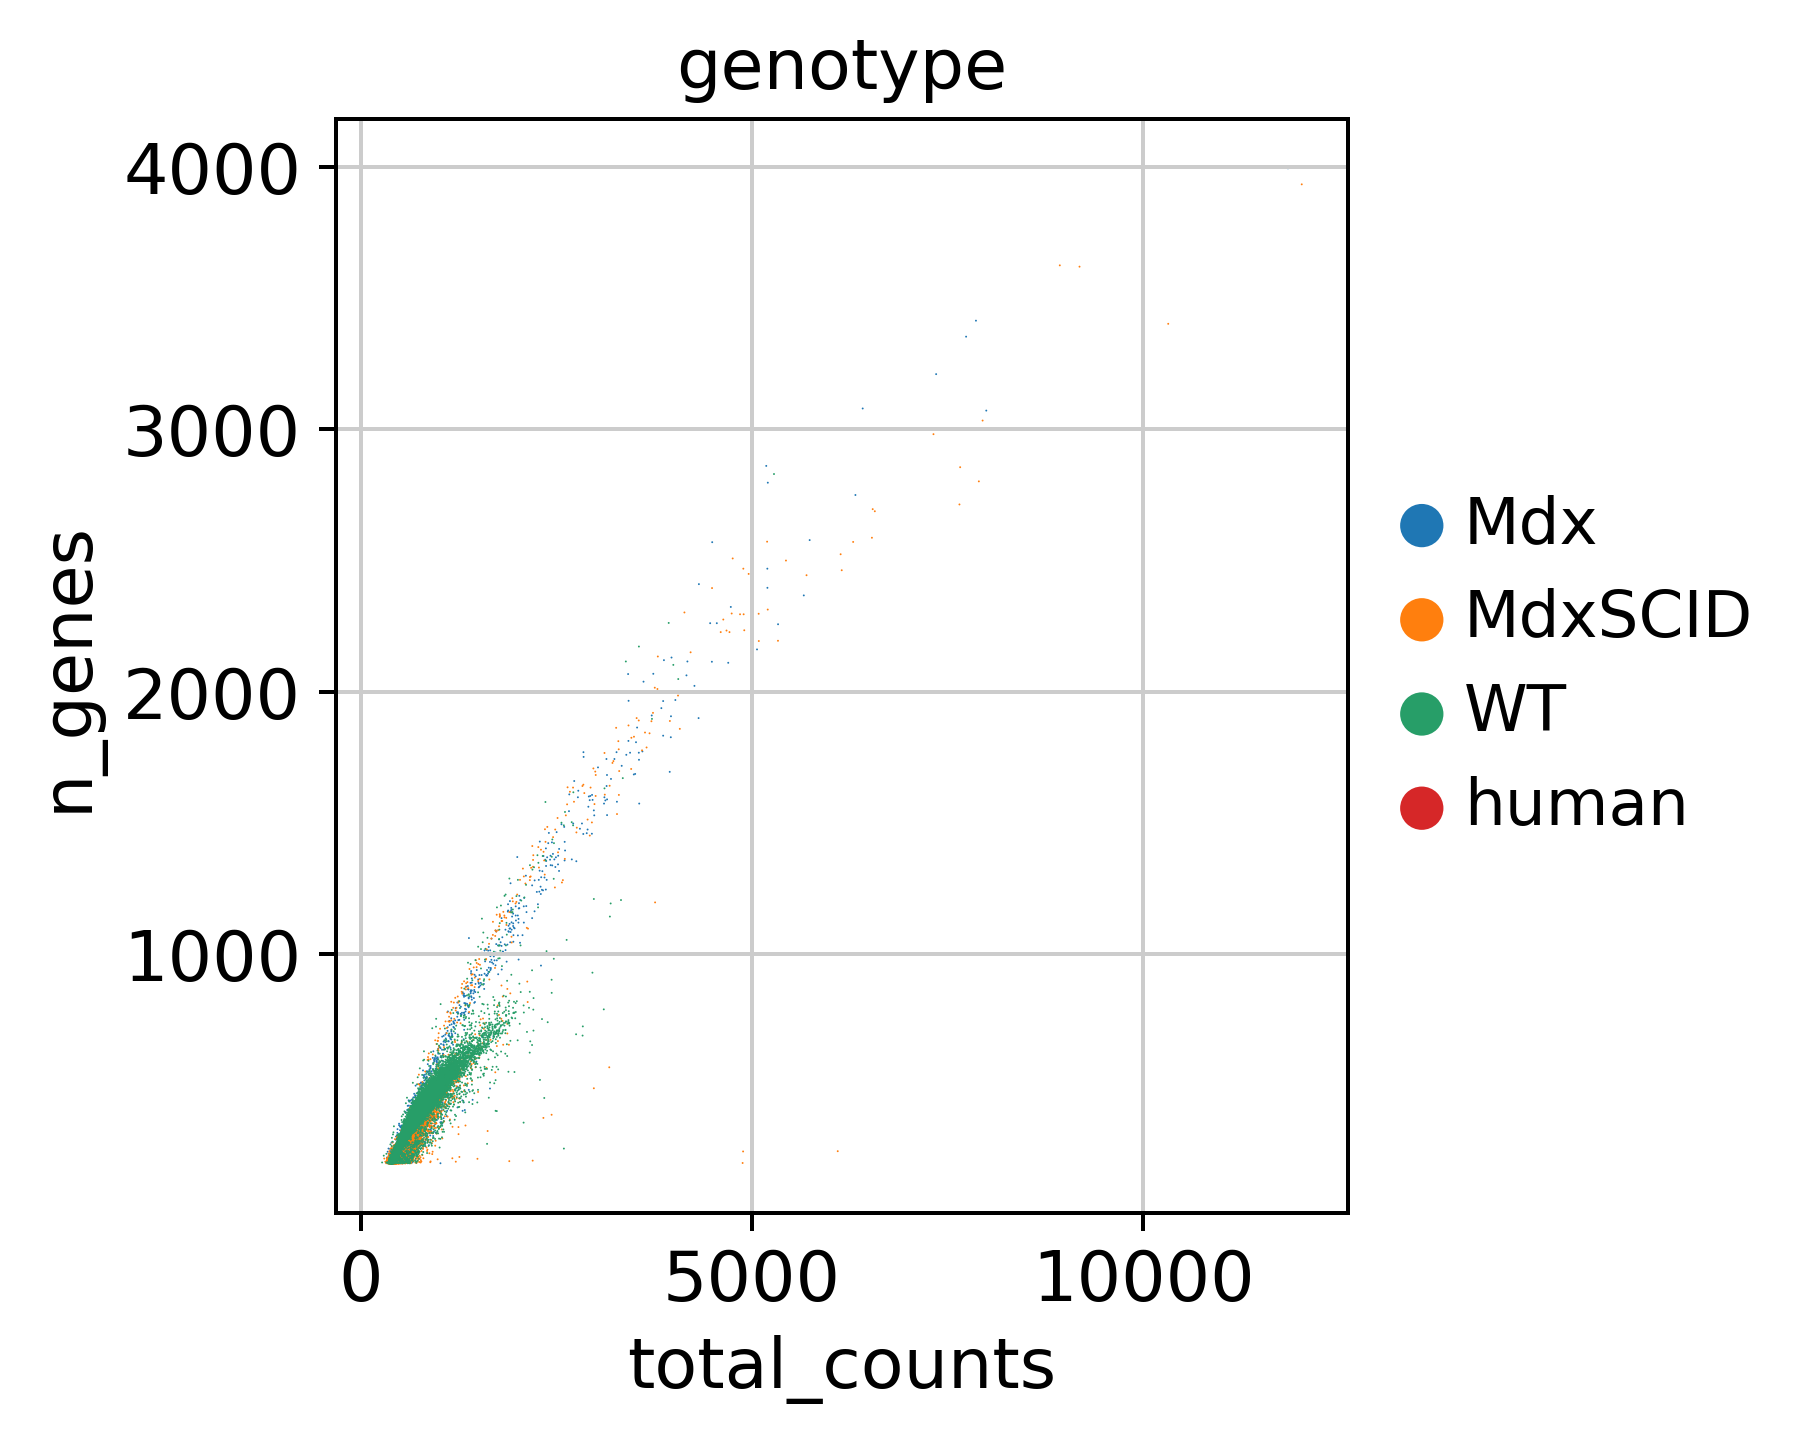

In [45]:
sc.pl.scatter(adata, x = 'total_counts', y = 'n_genes', color = "genotype", frameon = False)

In [46]:
adata.obs['genotype'].value_counts()

genotype
human      141738
WT          49318
MdxSCID     13495
Mdx          2731
Name: count, dtype: int64

In [47]:
adata.obs['sample'].value_counts()

sample
A10_2               46783
B1_2                 9650
NP13                 8737
NP23                 7619
AN13                 6860
NP18                 6388
AN7                  6165
NP24                 6139
NP28                 5914
AN12                 5564
NP44                 5458
NP19                 5444
AN2                  5180
NP22                 4993
NP39                 4951
NP31                 4695
NP17                 4692
NP36                 4439
NP32                 3514
NP21                 3486
NP37                 3441
NP30                 3404
AN9                  3387
NP41                 3297
NP26                 3236
AN6                  3173
NP38                 3106
AN5                  3010
NP15                 2973
NP27                 2694
NP20                 2081
B2_2                 1917
NP16                 1783
AN14                 1732
NP35                 1549
AN11                 1263
AN3                   765
A9_2                  684
AN1  

### Select HVGs

In [48]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "sample",
    subset = True,
    span = 1
)
adata

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 207282 × 7000
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment'
    var: 'gene_ids-DMD_immune-DMD', 'feature_types-DMD_immune-DMD', 'genome-DMD_immune-DMD', 'mt-DMD_immune-DMD', 'ribo-DMD_immune-DMD', 'n_cells_by_counts-DMD_immune-DMD', 'mean_counts-DMD_immune-DMD', 'pct_dropout_by_counts-DMD_immune-DMD', 'total_counts-DMD

### Transfer of annotation with scANVI

In [49]:
scvi.model.SCVI.setup_anndata(adata,
                              batch_key = "sample", 
                            categorical_covariate_keys = ["donor", "cell_source"], 
                            labels_key = "seed_labels", 
                            layer = 'counts')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [50]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 150, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [51]:
scvi_model.train(20, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 accelerator = 'gpu',
                 devices = [0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 20/20: 100%|██████████| 20/20 [02:48<00:00,  8.35s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=2.02e+3] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [02:48<00:00,  8.44s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=2.02e+3]


In [52]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

### Evaluate model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

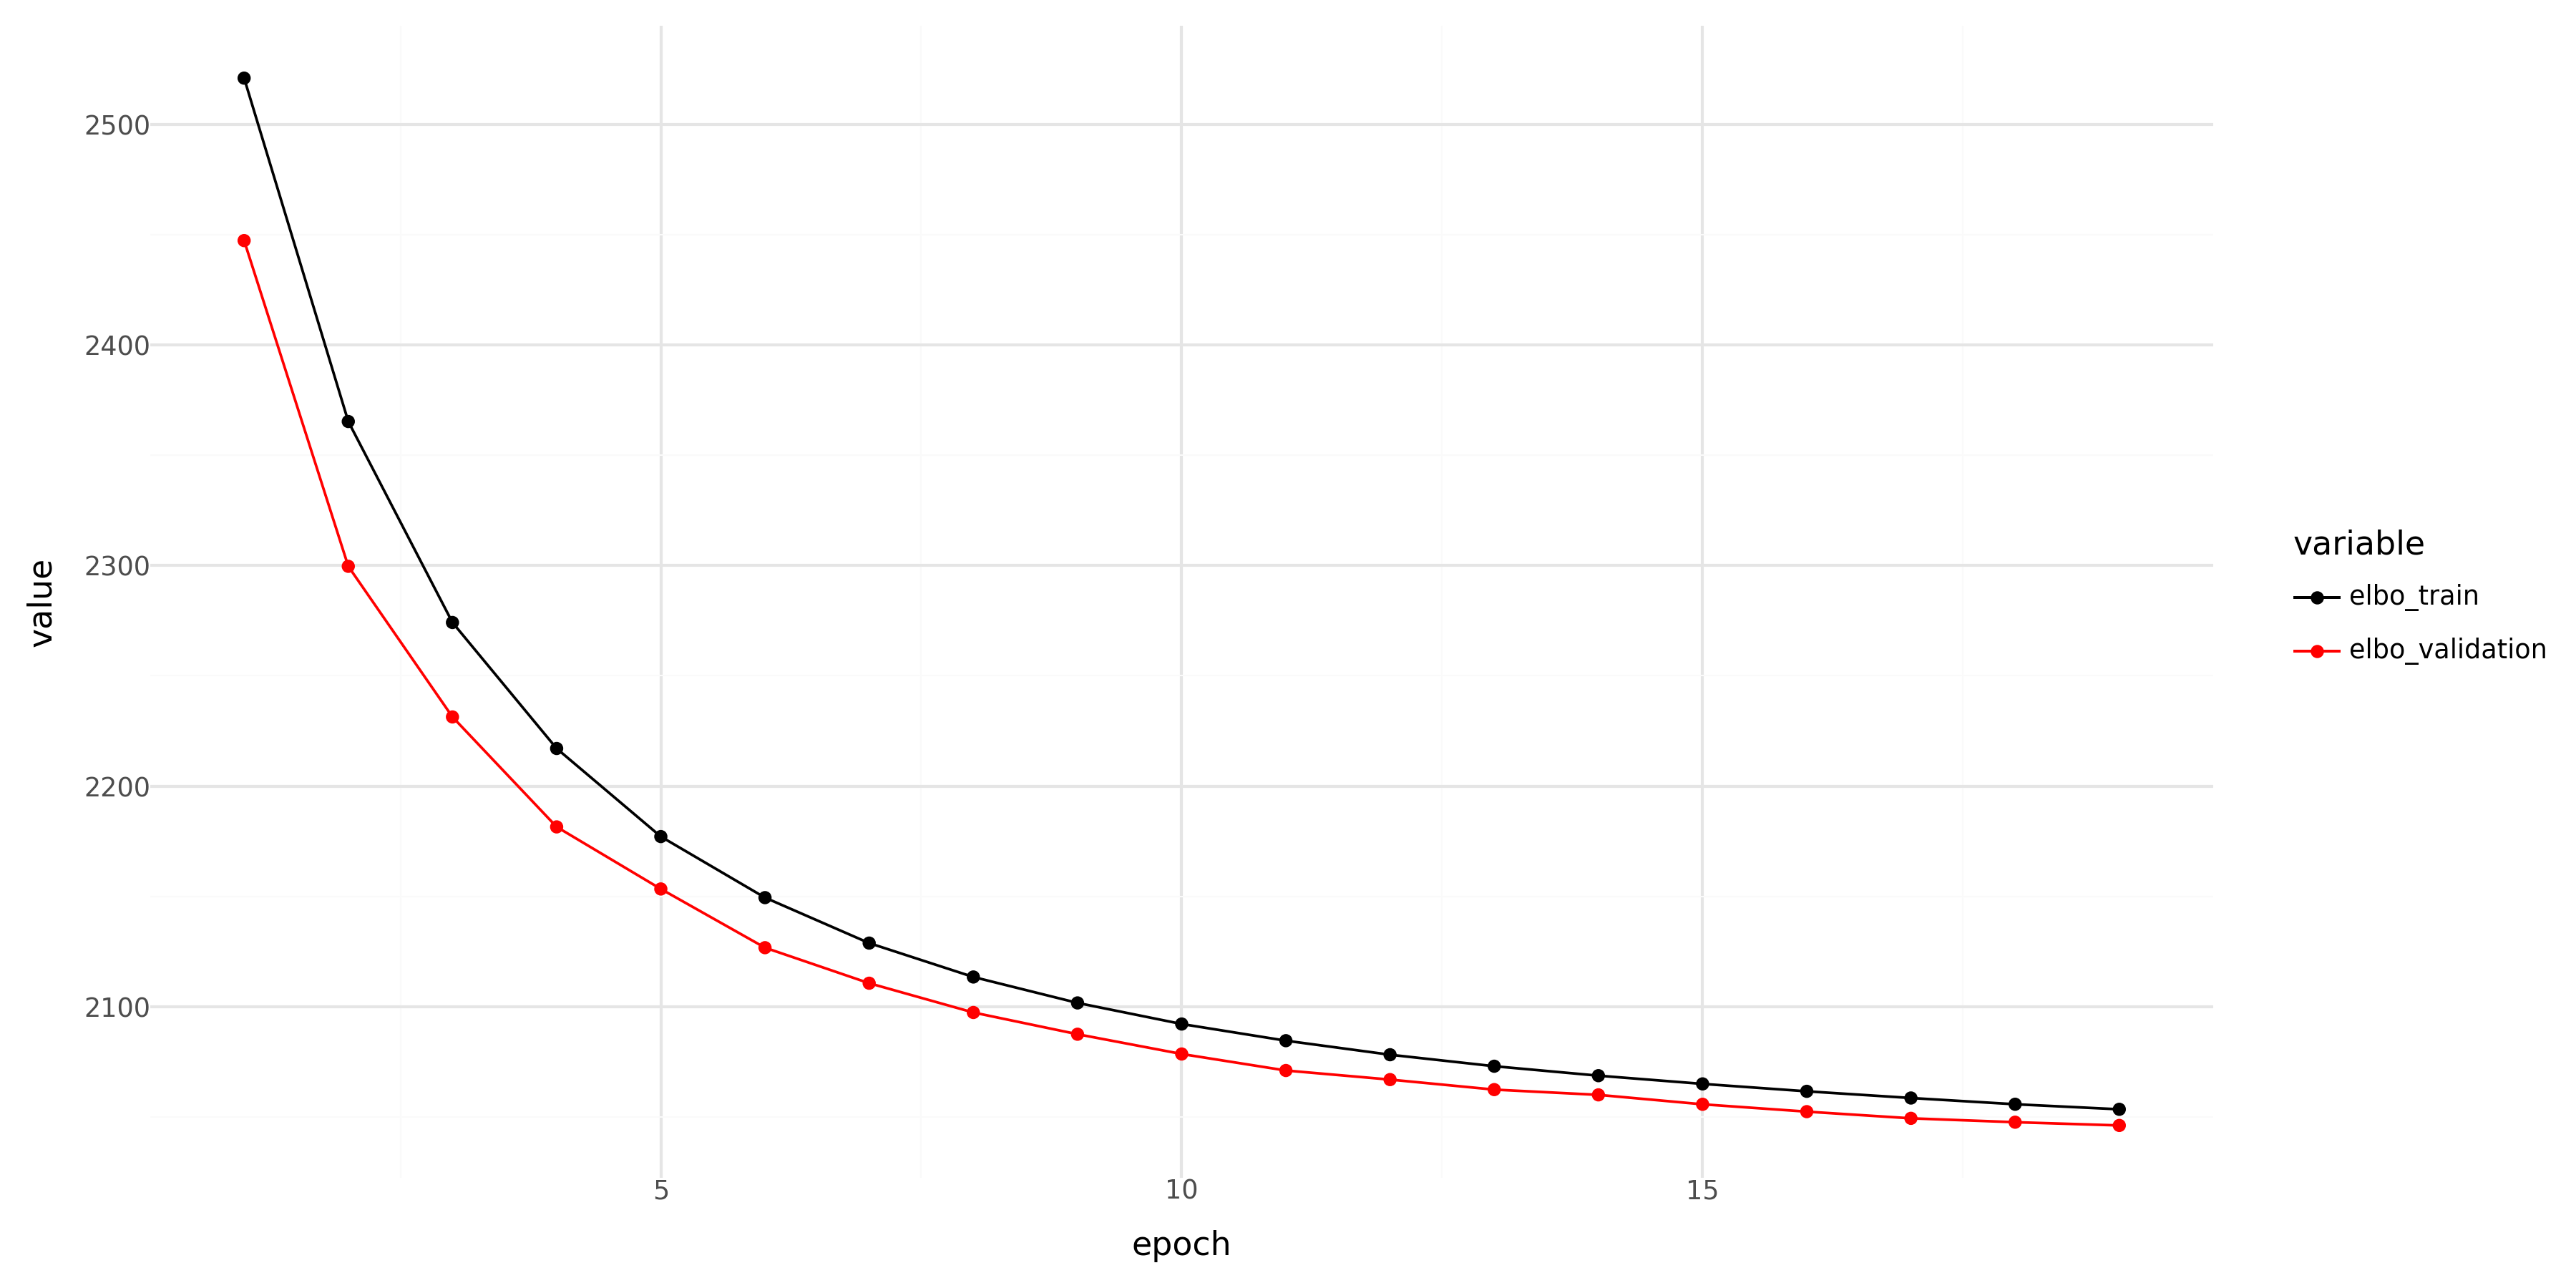

In [53]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [54]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [55]:
scanvi_model.train(20, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 accelerator = 'gpu',
                 devices = [0])

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 9/20:  40%|████      | 8/20 [02:56<04:13, 21.11s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.01e+3]

In [ ]:
adata.obs["C_scANVI_S1"] = scanvi_model.predict(adata)

- Extract latent representation

In [ ]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

### Explore model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

In [ ]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Visualise corrected dataset

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 3, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['genotype', 'C_scANVI_S1', 'cell_source', 'seed_labels', 'sample'], size = 0.8, legend_fontsize = 5, ncols = 3)

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['n_genes', 'doublet_scores', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts'], size = 1, legend_fontsize = 5, ncols = 4, cmap = 'magma')

### Modify object to plot canonical marker genes

In [ ]:
adata_toplot = anndata.AnnData(X = np.sqrt(sc.pp.normalize_total(adata_raw, inplace = False)["X"]), var = adata_raw.var, obs = adata.obs, obsm = adata.obsm)
adata_toplot

In [ ]:
sc.pl.umap(adata_toplot, frameon = False, color = ['C_scANVI_S1', 'C1qa', 'Cd3e', 'Trem2', 'Adipoq', 'Nrxn1', 'Msln'], size = 1, legend_fontsize = 5, ncols = 4, cmap = 'RdPu')

### Visualise proportions

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['sample', 'genotype', 'C_scANVI_S1'], size = 0.6, legend_fontsize = 5, ncols = 4)

In [ ]:
bauhaus_colors = ['#FF0000', '#FFFF00', '#000000', '#4D5D53', '#0000FF', '#808080']

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['genotype'], size = 0.6, legend_fontsize = 5, ncols = 4, palette = bauhaus_colors)

In [ ]:
df = adata_toplot.obs.groupby(['genotype', 'C_scANVI_S1']).size().reset_index(name = 'counts')

grouped = df.groupby('genotype')['counts'].apply(lambda x: x / x.sum() * 100)
grouped = grouped.reset_index()

df['proportions'] = grouped['counts']
df['waffle_counts'] = (df['proportions'] * 10).astype(int)

In [ ]:
def generate_modified_bauhaus_palette(n_colors):
    # Define specific shades
    base_colors = [
        (1, 0, 0),      # Red
        (0.07, 0.04, 0.56),  # Ultramarine blue
        (0, 0.28, 0.67),  # Cobalt blue
        (1, 0.9, 0),  # Bauhaus yellow
        (0, 0, 0),  # Black
        (0.5, 0, 0.5),  # Purple
        (1, 0.55, 0),  # Orange
        (0.54, 0.17, 0.89),  # Violet
    ]

    # Create more distinct variations of each base color
    colors = []
    variation_steps = n_colors // len(base_colors) + 1
    for color in base_colors:
        for i in range(variation_steps):
            # Adjusting brightness and saturation
            variation = tuple(min(max(c * (0.8 + i * 0.1), 0), 1) for c in color)
            colors.append(variation)

    # Ensure we only use the number of colors needed
    unique_colors = []
    for color in colors:
        if color not in unique_colors:
            unique_colors.append(color)
        if len(unique_colors) == n_colors:
            break

    # Shuffle the unique colors
    np.random.shuffle(unique_colors)

    return unique_colors

# Generate the modified palette
bauhaus_palette = generate_modified_bauhaus_palette(18)

In [ ]:
for group in df['genotype'].unique():
    temp_df = df[df['genotype'] == group]
    data = dict(zip(temp_df['C_scANVI_S1'], temp_df['waffle_counts']))

    # Ensure the color list matches the number of cell types
    colors = [bauhaus_palette[i % len(bauhaus_palette)] for i in range(len(temp_df['C_scANVI_S1']))]

    fig = plt.figure(
        FigureClass=Waffle, 
        rows=7, 
        values=data, 
        title={'label': f'Genotype {group}', 'loc': 'left', 'fontsize': 14},
        labels=[f"{k} ({v}%)" for k, v in zip(temp_df['C_scANVI_S1'], temp_df['proportions'].round(2))],
        legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0, 'fontsize': 14},
        figsize=(40, 4),
        colors=colors
    )
    plt.show()

### Prepare object for export

- Fix label for cell annotation

In [ ]:
adata.obs['cell_type'] = adata.obs['C_scANVI_S1'].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type'].cat.categories

In [ ]:
adata

In [ ]:
adata_query = adata[adata.obs['compartment'].isin(['MDX_POOL_NEW', 'DMD', 'MDX_MPC'])]
adata_query

In [ ]:
pd.crosstab(adata_query.obs['cell_type'], adata_query.obs['genotype'])

In [ ]:
adata_export_raw.obs['cell_type'] = adata_query.obs['cell_type'].copy()

In [ ]:
common_obs_names = adata_export_raw.obs_names[adata_export_raw.obs_names.isin(adata_query.obs_names)]
common_obs_names

In [ ]:
adata_subset = adata_export_raw[common_obs_names]
adata_subset

In [ ]:
# Remove duplicate obs_names from adata_export_raw
adata_export_raw.obs_names_make_unique()

# Remove duplicate obs_names from adata_export
adata_export.obs_names_make_unique()

# Get the common obs_names between adata_export_raw and adata_export
common_obs_names = adata_export_raw.obs_names.isin(adata_export.obs_names)

# Create a new AnnData object with the common cells
adata_subset = adata_export_raw[common_obs_names]

# Assign 'cell_type' and 'genotype' columns to the new subset
adata_subset.obs['cell_type'] = adata_export.obs.loc[common_obs_names, 'cell_type']
adata_subset.obs['genotype'] = adata_export.obs.loc[common_obs_names, 'genotype']

In [ ]:
adata_subset

In [ ]:
pd.crosstab(adata_subset.obs['cell_type'], adata_subset.obs['genotype'])